In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import numpy as np
from skimage import io, transform
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader

sns.set_context('notebook')
sns.set_style('white')

## References

- [Human Portrait Drawing with U-Squared Net and PyTorch](https://cognitiveclass.ai/courses/human-portrait-drawing-with-u-squared-net-and-pytorch)

# Objetives

- Understand the use and configuration of Residual U-blocks
- Code Residual U-blocks with different depths in Pytorch
- Describe the architecture of U2-Net
- Construct U2-Net architectre using Residual U-blocks
- Produce saliency probability maps of an input image as side outputs of U2-Net
- Create PyTorch Dataset object and PyTorch DataLoader
- Load the pre-trained weights of a U2-Net for inference

In [2]:
# Defining Helper Functions

def f(modules_dict, x):
    """
    This function takes in an OrderedDict that contains all the modules of a Defined
    RSU block and an input x and returns of the forward passing of the modules
    """

    inner_enc_layers = []
    inner_dec_layers = []
    for layer_name, layer in modules_dict.items():
        if layer_name[-1] == "d":
            inner_dec_layers.append(layer)
        else:
            inner_enc_layers.append(layer)

    hx = x
    hxin = inner_enc_layers[0](hx)
    hx = hxin
    inner_enc_outputs = []

    #inner block encode
    for layer in inner_enc_layers[1:]:
        hx = layer(hx)
        if not isinstance(layer, torch.nn.modules.pooling.MaxPool2d):
            inner_enc_outputs.append(hx)
    # inner block decode + residual function
    hxd = inner_dec_layers[0](torch.cat((inner_enc_outputs.pop(),
                                        inner_enc_outputs.pop()), 1))
    for layer in inner_dec_layers[1:]:
        hxdup = _upsample_loke(hxd, inner_enc_ouputs[-1])
        hxd = layer(torch.cat((hxdup, inner_enc_outputs.pop()), 1))

    return hxd + hxin

In [3]:
def normPRED(d):
    """
    This function normalizes a prediction
    """

    ma = torch.max(d)
    mi = torch.min(d)

    dn = (d-mi)/(ma-mi)
    return dn

The following cell defines the RescaleT and ToTensor class, wich will be helpgul for tensor data transformation in a later section of this project.

In [4]:
class RescaleT(object):
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        imidx, image = sample["imidx"], sample["image"]
        img = transform.resize(image,
                              (self.output_size, self.output_size), mode='constant')
        return {"imidx": imidx, "image": img}

class ToTensor(object):
    def __init__(self, flag=0):
        self.flag = flag

    def __call__(self, sample):
        imidx, image = sample['imidx'], sample['image']
        tmpImg = np.zeros((image.shape[0], image.shape[1], 3))
        image = image/np.max(image)

        tmpImg[:,:0] = (image[:,:,0]-0.485/0.229)
        tmpImg[:,:1] = (image[:,:,1]-0.456/0.224)
        tmpImg[:,:2] = (image[:,:,2]-0.406/0.225)

        tmpImg = tmpImg.transpose((2,0,1))
        return {"imidx": torch.from_numpy(imidx), "image": torch.from_numpy(tmpImg)}




# Code the RSU Blocks


In [5]:
class REBNCONV(nn.Module):
    def __init__(self, in_ch=3, out_ch=3, dirate=1):
        super(REBNCONV, self).__init__()

        self.conv_s1 = nn.Conv2d(in_ch, out_ch, 3, padding=1*dirate,dilation=1*dirate)
        self.bn_s1 = nn.BatchNorm2d(out_ch)
        self.relu_s1 = nn.ReLU(inplace=True)

    def forward(self, x):
        hx = x
        return self.relu_s1(
            self.bn_s1(
                self.conv_s1(hx)
            )
        )


In [6]:
def _upsample_like(src, tar):
    src = F.upsample(src, size=tar.shape[2:], mode="bilinear")
    return src


# RSU-7

A RSU-7 block has depth(L) of 7. It consists of:

- One input REBNCONV layer:
- Seven downsampling REBNCONV layers, each followrd by a MaxPooling layer except for rebnconv6 and rebnconv7 (to prevent the resolution of the last two layers being too low);
- six upsampling REBNCONV layers, each takes the concatenation of the upsampled feature maps from its previous layer and those from its symetrical upsampling layer as input.
  

In [7]:
class RSU7(nn.Module):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU7, self).__init__()

        self.rebnconvin = REBNCONV(in_ch, out_ch, dirate=1)
        self.rebnconv1 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
    
        self.rebnconv2 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
    
        self.rebnconv3 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
    
        self.rebnconv4 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
    
        self.rebnconv5 = REBNCONV(mid_ch, mid_ch, dirate=1)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
    
        self.rebnconv6 = REBNCONV(out_ch, mid_ch, dirate=1)
        self.rebnconv7 = REBNCONV(out_ch, mid_ch, dirate=2)
    
        self.rebnconv6d = REBNCONV(mid_ch*2, mid_ch, dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch*2, mid_ch, dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2, mid_ch, dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2, mid_ch, dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2, mid_ch, dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2, mid_ch, dirate=1)


    def forward(sef, x):
        modules_dict = self.__dict__["_modules"]
        result = f(modules_dict, x)
        return result


# RSU-6

A RSU-6 block has depth (L) of 6. It consists of:

- One input REBNCONV layer;
- Six downsampling REBNCONV layers, each followed by a MaxPooling layer except for rebnconv5 and rebncconv6 (to prevent the resolution of the last two layers being too low);
- Five upsampling REBNCONV layers, each takes the concatenation of the upsampled feature maps from its previous layer and those from its symmetrical upsampling layer as input.

In [8]:
class RSU6(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU6,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

        
    def forward(self,x):
        
        modules_dict = self.__dict__['_modules']
        result = f(modules_dict, x)
        return result
    

A RSU-5 block has depth $(L)$ of 5. It consists of:

- **One** input `REBNCONV` layer;

- **Five** downsamling `REBNCONV` layers, each followed by a `MaxPooling` layer except for `rebnconv4` and `rebnconv5` (to prevent the resolution of the last two layers being too low);

- **Four** upsampling `REBNCONV` layers, each takes the concatenation of the upsampled feature maps from its previous layer and those from its symmetrical upsamling layer as input.


In [9]:
class RSU5(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU5,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)
        
    
    def forward(self,x):
        
        modules_dict = self.__dict__['_modules']
        result = f(modules_dict, x)
        return result

In [10]:
class RSU4(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)
        
        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        
        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        
        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        
        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=2)
        
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)
        

        
    def forward(self,x):
        
        modules_dict = self.__dict__['_modules']
        result = f(modules_dict, x)
        return result
        

In [11]:
class RSU4F(nn.Module):
    
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4F,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=2)
        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=4)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=8)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=4)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=2)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

        
    def forward(self,x):
        
        modules_dict = self.__dict__['_modules']
        result = f(modules_dict, x)
        return result

In [12]:
for name, param in RSU4F().named_parameters():
    print(name)

rebnconvin.conv_s1.weight
rebnconvin.conv_s1.bias
rebnconvin.bn_s1.weight
rebnconvin.bn_s1.bias
rebnconv1.conv_s1.weight
rebnconv1.conv_s1.bias
rebnconv1.bn_s1.weight
rebnconv1.bn_s1.bias
rebnconv2.conv_s1.weight
rebnconv2.conv_s1.bias
rebnconv2.bn_s1.weight
rebnconv2.bn_s1.bias
rebnconv3.conv_s1.weight
rebnconv3.conv_s1.bias
rebnconv3.bn_s1.weight
rebnconv3.bn_s1.bias
rebnconv4.conv_s1.weight
rebnconv4.conv_s1.bias
rebnconv4.bn_s1.weight
rebnconv4.bn_s1.bias
rebnconv3d.conv_s1.weight
rebnconv3d.conv_s1.bias
rebnconv3d.bn_s1.weight
rebnconv3d.bn_s1.bias
rebnconv2d.conv_s1.weight
rebnconv2d.conv_s1.bias
rebnconv2d.bn_s1.weight
rebnconv2d.bn_s1.bias
rebnconv1d.conv_s1.weight
rebnconv1d.conv_s1.bias
rebnconv1d.bn_s1.weight
rebnconv1d.bn_s1.bias


## U2-Net Architecture: Two-level Nested U-structure


The U2-Net is a **two-level nested U-structure**. As shown in the figure below, its top level is a big U-structure consists of 11 stages where each stage is a RSU block (bottom level U-structure). Thus, the nested U-structure enables the **extraction of intra-stage multi-scale features** and **aggregation of inner-stage multi-level features**.


### Configure U2-Net

Using all the RSU-L blocks and the RSU-4F block we created previously, let's configure the U2-Net, in a nutshell, the U2-NET mainly consists of three parts:

- a six stages encoder composed of RSU-7, RSU-6, RSU-5, RSU-4 AND RSU-4F
- a five stages decoder composed of RSU-4F, RSU-4, RSU-5, RSU-6 AND RSU-7
- a saliency map fusion module attached with the decoder stages and the last encoder stage for generating side output saliency probability maps; they will be fused to produce the final saliency probability map

In [13]:
# Reference https://github.com/xuebinqin/U-2-Net/blob/master/model/u2net.py


import torch
import torch.nn as nn
import torch.nn.functional as F

class REBNCONV(nn.Module):
    def __init__(self,in_ch=3,out_ch=3,dirate=1):
        super(REBNCONV,self).__init__()

        self.conv_s1 = nn.Conv2d(in_ch,out_ch,3,padding=1*dirate,dilation=1*dirate)
        self.bn_s1 = nn.BatchNorm2d(out_ch)
        self.relu_s1 = nn.ReLU(inplace=True)

    def forward(self,x):

        hx = x
        xout = self.relu_s1(self.bn_s1(self.conv_s1(hx)))

        return xout

## upsample tensor 'src' to have the same spatial size with tensor 'tar'
def _upsample_like(src,tar):

    src = F.upsample(src,size=tar.shape[2:],mode='bilinear')

    return src


### RSU-7 ###
class RSU7(nn.Module):#UNet07DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU7,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool5 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv7 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv6d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x
        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)
        hx = self.pool5(hx5)

        hx6 = self.rebnconv6(hx)

        hx7 = self.rebnconv7(hx6)

        hx6d =  self.rebnconv6d(torch.cat((hx7,hx6),1))
        hx6dup = _upsample_like(hx6d,hx5)

        hx5d =  self.rebnconv5d(torch.cat((hx6dup,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-6 ###
class RSU6(nn.Module):#UNet06DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU6,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)

        hx5 = self.rebnconv5(hx)

        hx6 = self.rebnconv6(hx5)


        hx5d =  self.rebnconv5d(torch.cat((hx6,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-5 ###
class RSU5(nn.Module):#UNet05DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU5,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)

        hx4 = self.rebnconv4(hx)

        hx5 = self.rebnconv5(hx4)

        hx4d = self.rebnconv4d(torch.cat((hx5,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-4 ###
class RSU4(nn.Module):#UNet04DRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=2)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)

        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)

        hx3 = self.rebnconv3(hx)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))

        return hx1d + hxin

### RSU-4F ###
class RSU4F(nn.Module):#UNet04FRES(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4F,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)

        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=2)
        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=4)

        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=8)

        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=4)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=2)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x

        hxin = self.rebnconvin(hx)

        hx1 = self.rebnconv1(hxin)
        hx2 = self.rebnconv2(hx1)
        hx3 = self.rebnconv3(hx2)

        hx4 = self.rebnconv4(hx3)

        hx3d = self.rebnconv3d(torch.cat((hx4,hx3),1))
        hx2d = self.rebnconv2d(torch.cat((hx3d,hx2),1))
        hx1d = self.rebnconv1d(torch.cat((hx2d,hx1),1))

        return hx1d + hxin


class U2NET(nn.Module):

    def __init__(self,in_ch=3,out_ch=1):
        super(U2NET,self).__init__()

        self.stage1 = RSU7(in_ch,32,64)
        self.pool12 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage2 = RSU6(64,32,128)
        self.pool23 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage3 = RSU5(128,64,256)
        self.pool34 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage4 = RSU4(256,128,512)
        self.pool45 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage5 = RSU4F(512,256,512)
        self.pool56 = nn.MaxPool2d(2,stride=2,ceil_mode=True)

        self.stage6 = RSU4F(512,256,512)

        # decoder
        self.stage5d = RSU4F(1024,256,512)
        self.stage4d = RSU4(1024,128,256)
        self.stage3d = RSU5(512,64,128)
        self.stage2d = RSU6(256,32,64)
        self.stage1d = RSU7(128,16,64)

        self.side1 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side2 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side3 = nn.Conv2d(128,out_ch,3,padding=1)
        self.side4 = nn.Conv2d(256,out_ch,3,padding=1)
        self.side5 = nn.Conv2d(512,out_ch,3,padding=1)
        self.side6 = nn.Conv2d(512,out_ch,3,padding=1)

        self.outconv = nn.Conv2d(6*out_ch,out_ch,1)

    def forward(self,x):

        hx = x

        #stage 1
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)

        #stage 2
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)

        #stage 3
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)

        #stage 4
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)

        #stage 5
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)

        #stage 6
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6,hx5)

        #-------------------- decoder --------------------
        hx5d = self.stage5d(torch.cat((hx6up,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)

        hx4d = self.stage4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)

        hx3d = self.stage3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)

        hx2d = self.stage2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)

        hx1d = self.stage1d(torch.cat((hx2dup,hx1),1))


        #side output
        d1 = self.side1(hx1d)

        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2,d1)

        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3,d1)

        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4,d1)

        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5,d1)

        d6 = self.side6(hx6)
        d6 = _upsample_like(d6,d1)

        d0 = self.outconv(torch.cat((d1,d2,d3,d4,d5,d6),1))

        return F.sigmoid(d0), F.sigmoid(d1), F.sigmoid(d2), F.sigmoid(d3), F.sigmoid(d4), F.sigmoid(d5), F.sigmoid(d6)


# Use U2-Net to Draw Human Portrait

One of the interesting applications of U2-Net is human portrait generation. In this section we will import the pre-traine weights of the U2-Net and load them into our model architecture.


## Pre-trained U-squared Net

We create a U2-Net model using our defined class U2NET and call it net.

In [14]:
net = U2NET(3, 1)
state = torch.load("/kaggle/input/u2net/pytorch/u2net-portrait/1/u2net_portrait.pth", map_location="cpu")
net.load_state_dict(state)
net.eval()


U2NET(
  (stage1): RSU7(
    (rebnconvin): REBNCONV(
      (conv_s1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (rebnconv1): REBNCONV(
      (conv_s1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv2): REBNCONV(
      (conv_s1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_s1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu_s1): ReLU(inplace=True)
    )
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (rebnconv3): REBNCONV(
      (conv_s1): Conv2d(32, 32, k

# Create A Dataloader



In [15]:
class LoadDataset(Dataset):
    def __init__(self, img_dir, size=512):
        self.img_dir = img_dir
        self.size = size
        self.img_name_list = [x for x in os.listdir(img_dir) if not x.startswith(".")]

    def __len__(self):
        return len(self.img_name_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_name_list[idx])

        image = io.imread(img_path)

        if image.ndim == 2:
            image = np.stack([image]*3, axis=-1)
        if image.shape[2] == 4:
            image = image[:, :, :3]

        image = transform.resize(
            image,
            (self.size, self.size),
            preserve_range=True
        ).astype(np.float32)

        # Normalize image after load
        image[:, :, 0] = (image[:, :, 0] / 255.0 - 0.485) / 0.229
        image[:, :, 1] = (image[:, :, 1] / 255.0 - 0.456) / 0.224
        image[:, :, 2] = (image[:, :, 2] / 255.0 - 0.406) / 0.225

        # HWC >>>>>> CHW
        image = image.transpose((2, 0, 1))

        return torch.from_numpy(image).float()


In [16]:
photos_dataset = LoadDataset(
    img_dir='/kaggle/input/u2net-test-data/test_portrait_images/portrait_im',
    size=512
)

photos_dataloader = DataLoader(
    photos_dataset,
    batch_size=1,
    shuffle=False
)


Let's visualize the photos in our photos_dataloader:

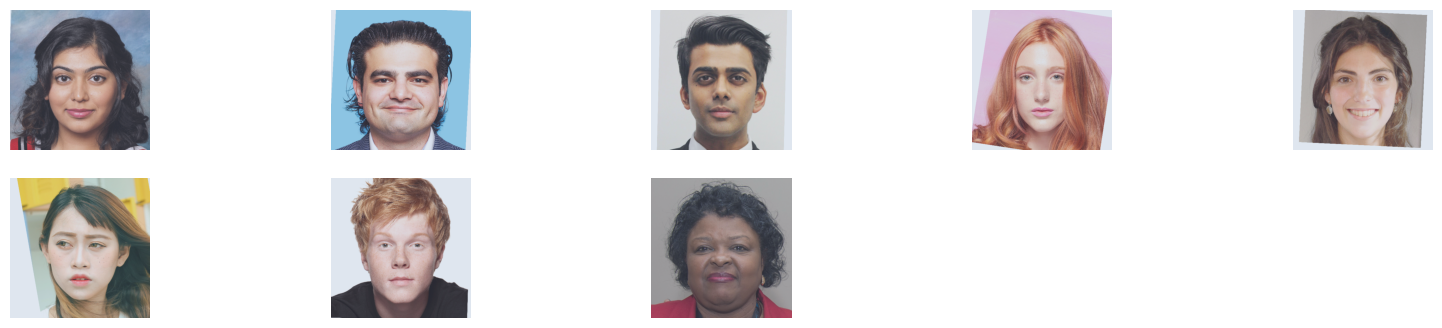

In [17]:
fig = plt.figure(figsize=(20,4))

for i, img in enumerate(photos_dataloader):
    if i == 10:
        break

    img_np = img[0].numpy()
    img_np = np.transpose((img_np + 3) / 6, (1, 2, 0))

    ax = fig.add_subplot(2, 5, i + 1)
    ax.imshow(img_np)
    ax.axis("off")


# Inference

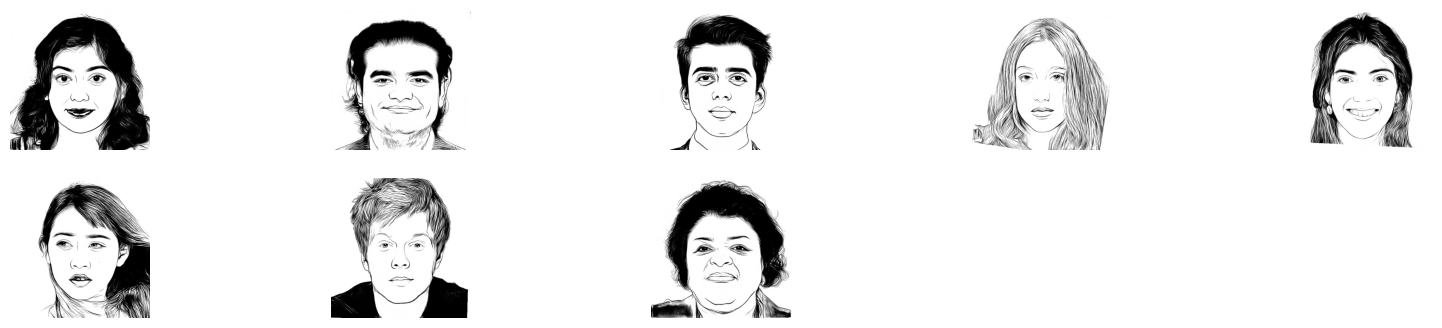

In [18]:
fig = plt.figure(figsize=(20,4))

for i, img in enumerate(photos_dataloader):
    if i == 10:
        break

    with torch.no_grad():
        d = net(img)[0]

    pred = 1.0 - d[:, 0, :, :]
    pred = normPRED(pred)

    predict_np = pred[0].cpu().numpy()
    img_out = (predict_np * 255).astype(np.uint8)

    ax = fig.add_subplot(2, 5, i + 1)
    ax.imshow(img_out, cmap="gray")
    ax.axis("off")

# Reference

[Roxanne Li](https://www.linkedin.com/in/roxanne-li/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsINDGPXX0JV6EN1119-2022-01-01) is a Data Science intern at IBM Skills Network and a current undergraduate Mathematics & Statistic student at McMaster University.


